In [50]:
%matplotlib notebook
import mne
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from scipy.signal import spectrogram, stft
from mne.time_frequency import tfr_array_morlet

In [2]:
# 31, 35, 38 and test folders for good data
# odd scalp on left, even on right

patient = 'UFSEEG031'
targetScalpElectrode = 'F7'

#filepath = '//ahcdfs.ahc.ufl.edu/files/NLGY/Groups/Epilepsy/KalamangalamLab/SEEG/%s/SEEG/EDF/TestClipSleep/TestClipSleep.edf' % patient
filepath = '../../../Desktop/TestClipSleep.edf'
raw = mne.io.read_raw_edf(filepath)

Extracting EDF parameters from C:\Users\the_m\Desktop\TestClipSleep.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


In [3]:
artifactElectrodes = {}
artifactElectrodes['UFSEEG031'] = ['LTP7', 'LTP8', 'LAH11', 'LAH12', 'LPH10', 'LPH11', 'LPH12','LOF15', 'LOF16']

In [4]:
scalpElectrodes = {}
scalpElectrodes[patient] = [i for i in raw.ch_names if len(i) == 2]
print(scalpElectrodes)

{'UFSEEG031': ['F7', 'F8', 'F3', 'F4', 'C3', 'C4', 'P7', 'P8', 'P3', 'P4', 'PR']}


In [5]:
print(raw)
print(raw.info)

<RawEDF | TestClipSleep.edf, 148 x 1766016 (1724.6 s), ~142 kB, data not loaded>
<Info | 7 non-empty values
 bads: []
 ch_names: LTP1, LTP2, LTP3, LTP4, LTP5, LTP6, LTP7, LTP8, LAM1, LAM2, ...
 chs: 148 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 512.0 Hz
 meas_date: 2001-01-01 02:05:22 UTC
 nchan: 148
 projs: []
 sfreq: 1024.0 Hz
>


Using matplotlib as 2D backend.


<IPython.core.display.Javascript object>


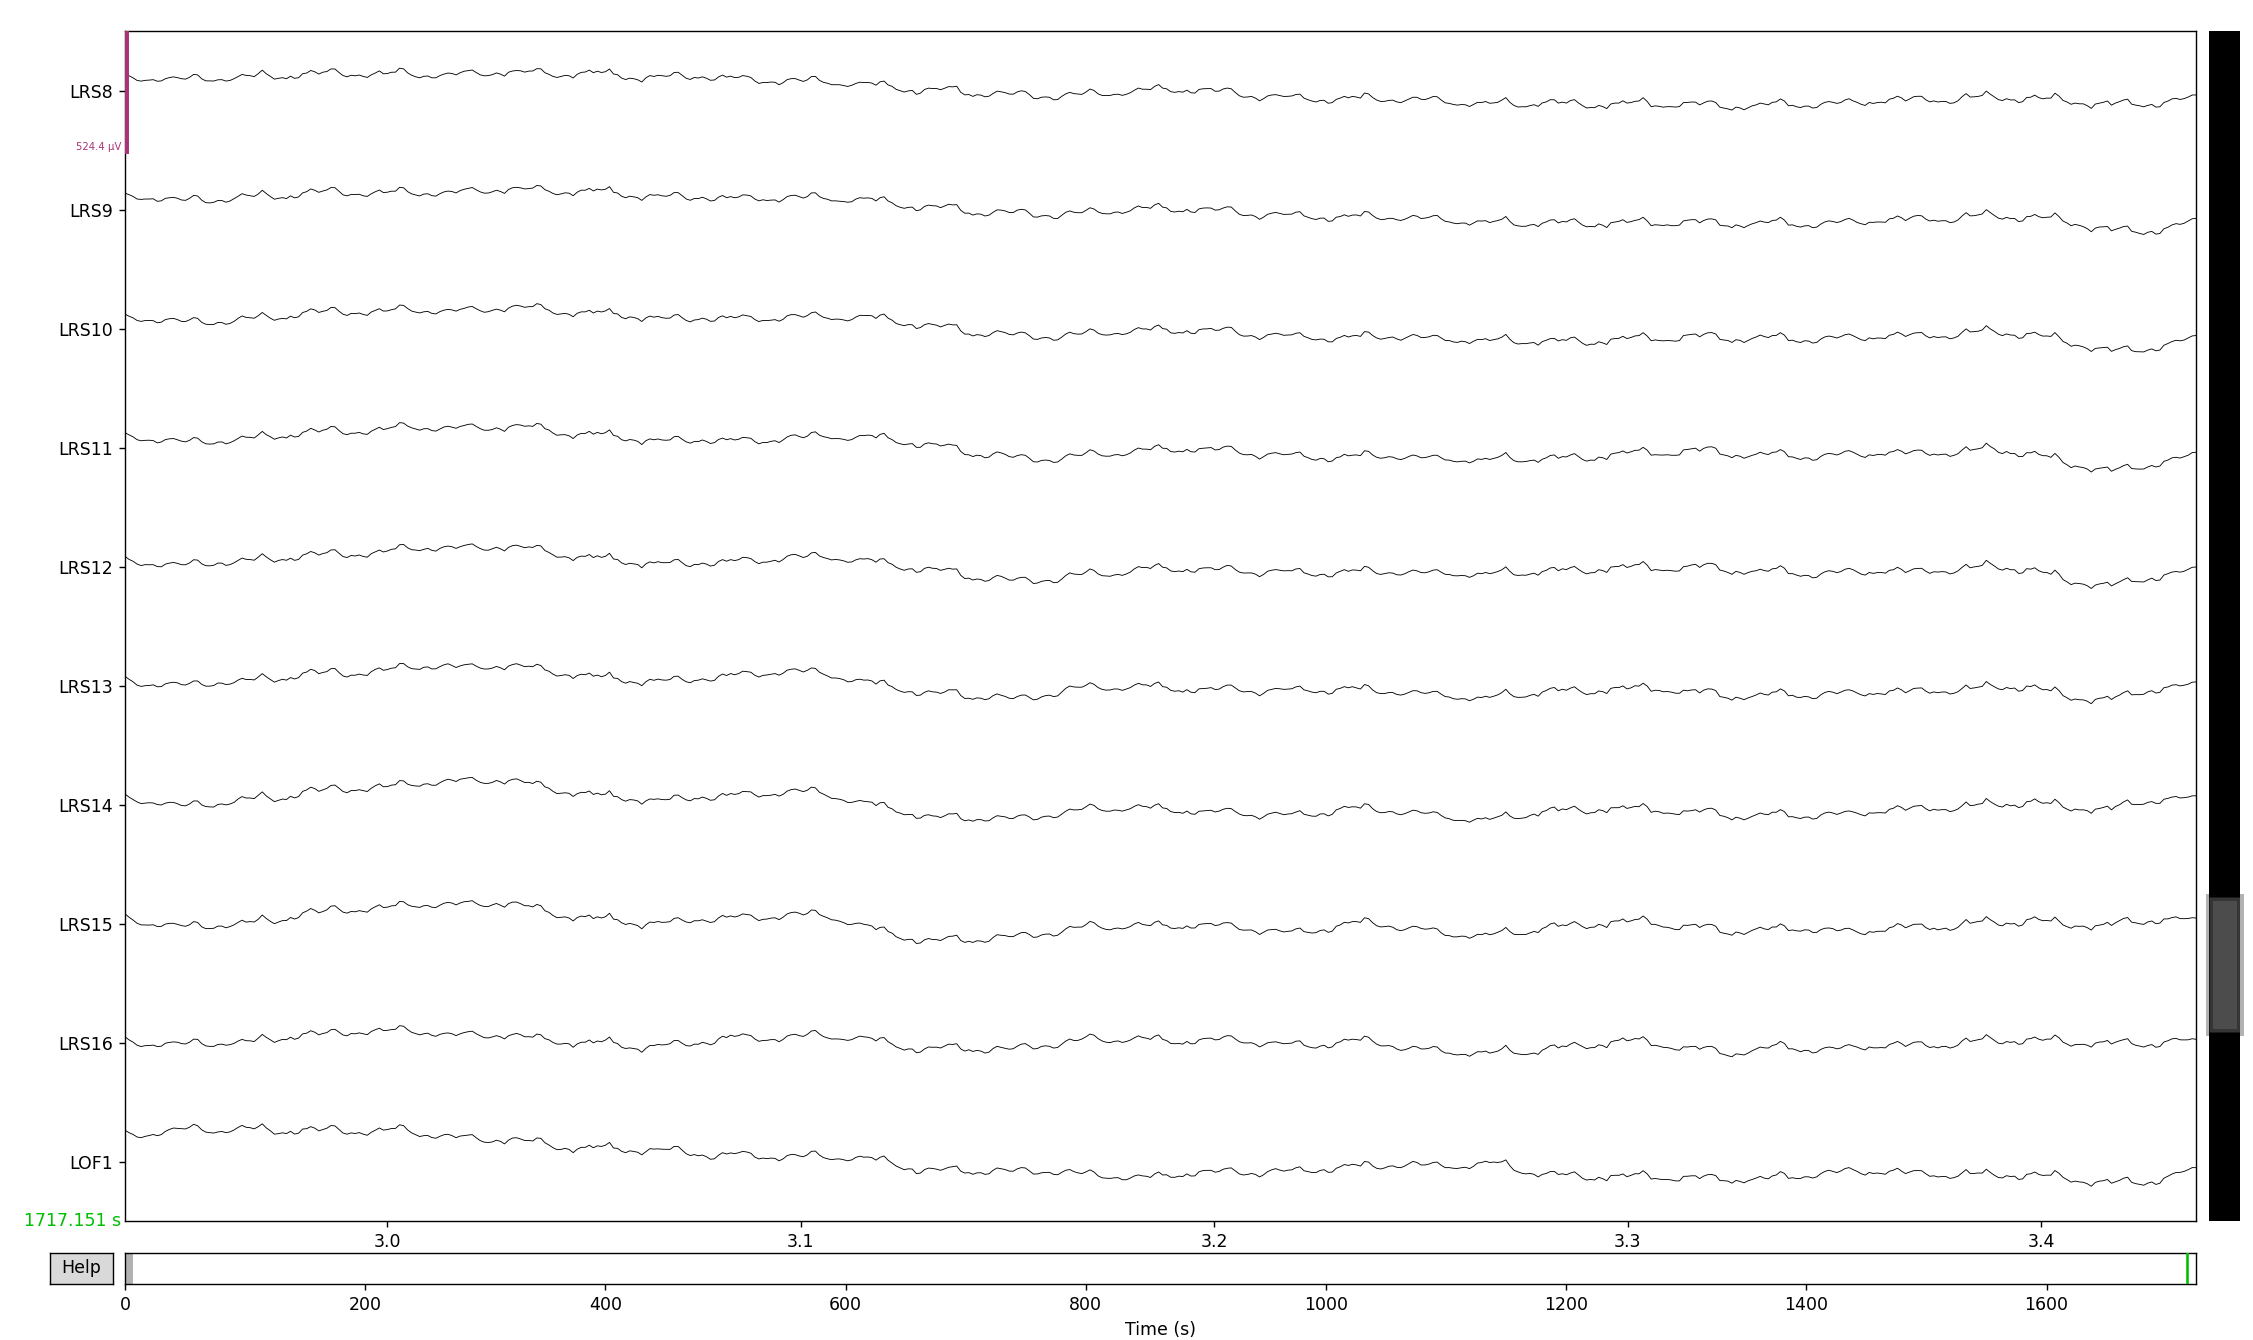

In [6]:
channels = [i for i in raw.ch_names if i not in artifactElectrodes[patient] and i[0] in {'L', 'R'}] + [targetScalpElectrode]
raw.pick_channels(channels).plot(duration=.5, n_channels=10);

In [7]:
df = raw.to_data_frame().drop(labels=['time'], axis=1)
data = df.to_numpy()
data = data - data.mean(axis=0, keepdims=True)
df

LTP1        LTP2        LTP3        LTP4        LTP5  \
0       -207.490211 -149.004822  -86.265949 -174.259876  -88.126848   
1       -201.375830 -138.371115  -76.163928 -163.360327  -78.024826   
2       -203.502571 -139.168643  -79.088197 -165.752911  -79.885725   
3       -215.465492 -156.980102  -93.177859 -179.842573  -96.102129   
4       -225.301671 -172.133135 -106.204150 -193.134707 -108.330892   
...             ...         ...         ...         ...         ...   
1766011   -0.132921   -0.132921   -0.132921   -0.132921   -0.132921   
1766012   -0.132921   -0.132921   -0.132921   -0.132921   -0.132921   
1766013   -0.132921   -0.132921   -0.132921   -0.132921   -0.132921   
1766014   -0.132921   -0.132921   -0.132921   -0.132921   -0.132921   
1766015   -0.132921   -0.132921   -0.132921   -0.132921   -0.132921   

              LTP6        LAM1        LAM2        LAM3        LAM4  ...  \
0        83.873365 -192.071336 -314.890654 -185.691112 -139.434485  ...   
1        94.241230 -181.969314 -303.991104 -174.791562 -129.332464  ...   
2        93.177859 -182.500999 -306.117845 -180.905943 -131.725048  ...   
3        79.354040 -195.261448 -318.878294 -198.185718 -147.143923  ...   
4        66.859434 -206.692683 -330.575372 -212.807065 -159.638529  ...   
...            ...         ...         ...         ...         ...  ...   
1766011  -0.132921   -0.132921   -0.132921   -0.132921   -0.132921  ...   
1766012  -0.132921   -0.132921   -0.132921   -0.132921   -0.132921  ...   
1766013  -0.132921   -0.132921   -0.132921   -0.132921   -0.132921  ...   
1766014  -0.132921   -0.132921   -0.132921   -0.132921   -0.132921  ...   
1766015  -0.132921   -0.132921   -0.132921   -0.132921   -0.132921  ...   

               LOF6       LOF7       LOF8       LOF9      LOF10      LOF11  \
0        -86.000107 -33.629099 -77.227298 -67.922805 -33.629099 -54.098985   
1        -73.239658 -19.273594 -62.871794 -53.833143 -19.539437 -42.136065   
2        -74.568872 -19.007752 -63.669322 -53.833143 -20.336965 -42.933593   
3        -89.721904 -32.565728 -77.758984 -67.125277 -34.692470 -57.554940   
4       -103.279881 -46.123705 -88.924376 -79.885725 -46.389548 -70.315389   
...             ...        ...        ...        ...        ...        ...   
1766011   -0.132921  -0.132921  -0.132921  -0.132921  -0.132921  -0.132921   
1766012   -0.132921  -0.132921  -0.132921  -0.132921  -0.132921  -0.132921   
1766013   -0.132921  -0.132921  -0.132921  -0.132921  -0.132921  -0.132921   
1766014   -0.132921  -0.132921  -0.132921  -0.132921  -0.132921  -0.132921   
1766015   -0.132921  -0.132921  -0.132921  -0.132921  -0.132921  -0.132921   

              LOF12       LOF13       LOF14         F7  
0        -79.088197 -208.553582 -174.525719  55.162356  
1        -68.454490 -194.995605 -162.296956  68.188647  
2        -71.378759 -198.451560 -163.892012  66.859434  
3        -85.468421 -214.933806 -179.576730  50.908873  
4       -100.089769 -231.416052 -192.868864  40.806851  
...             ...         ...         ...        ...  
1766011   -0.132921   -0.132921   -0.132921  -0.132921  
1766012   -0.132921   -0.132921   -0.132921  -0.132921  
1766013   -0.132921   -0.132921   -0.132921  -0.132921  
1766014   -0.132921   -0.132921   -0.132921  -0.132921  
1766015   -0.132921   -0.132921   -0.132921  -0.132921  

[1766016 rows x 88 columns]

In [20]:
scalpData = data[:,-1]
seegData = data[:,:-1]

x_train, x_valid, y_train, y_valid = train_test_split(seegData, scalpData, test_size=0.33, random_state=42)

train = lgb.Dataset(x_train, label=y_train, free_raw_data=False)
valid = train.create_valid(x_valid, label=y_valid)

In [63]:
trainIndices

array([      0,       1,       2, ..., 1400829, 1400830, 1400831])

In [92]:
# PARTITION TIME SERIES INTO CONTIGUOUS TRAIN AND VALIDATION BLOCKS

trainSize = .80
minutesInBlock = 6
nBlock = 4

sfreq = int(raw.info['sfreq'])
samplesPerBlock = sfreq * 60 * minutesInBlock
trainIndexProto = np.arange(0, samplesPerBlock * trainSize, dtype=int)
validIndexProto = np.arange(samplesPerBlock * trainSize, samplesPerBlock, dtype=int)

trainIndexBlocks = [trainIndexProto + (i * samplesPerBlock) for i in range(nBlock)]
validIndexBlocks = [validIndexProto + (i * samplesPerBlock) for i in range(nBlock)]

trainIndices = np.concatenate(trainIndexBlocks)
validationIndices = np.concatenate(validIndexBlocks)

perm = np.random.permutation(x_train.shape[0])

x_train = data[trainIndices,:-1]
y_train = data[trainIndices,-1]

x_train = x_train[perm, :]
y_train = y_train[perm]

x_valid = data[validationIndices, :-1]
y_valid = data[validationIndices, -1]

train = lgb.Dataset(x_train, label=y_train, free_raw_data=False)
valid = train.create_valid(x_valid, label=y_valid)

<IPython.core.display.Javascript object>


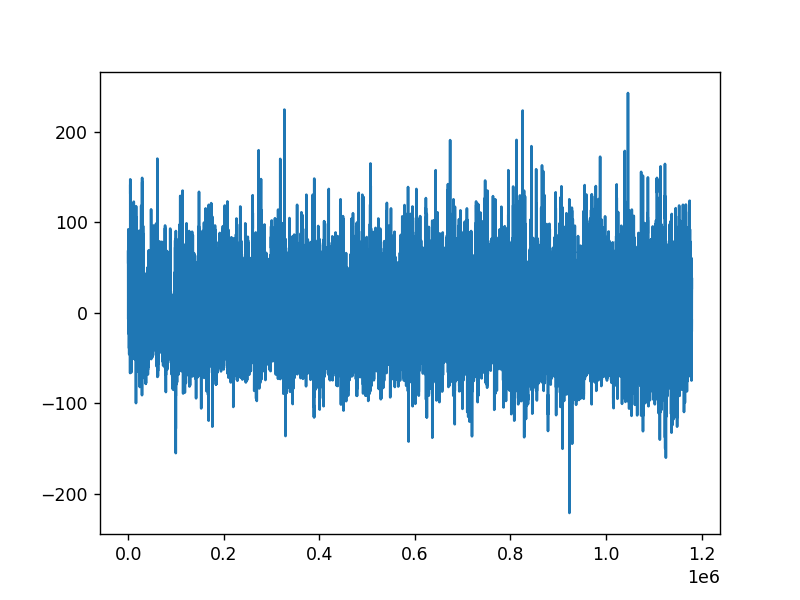

In [87]:
plt.figure
plt.plot(y_train)

In [93]:
continueFlag = False
if continueFlag:
    inputModel = 'model.txt'
else:
    inputModel = None

metric = 'mse'
num_iterations = 1000
early_stopping_rounds = 5

param = {'metric': metric, 
         'num_iterations': num_iterations,
         'early_stopping_rounds': early_stopping_rounds}

bst = lgb.train(param, 
                train, 
                valid_sets=[valid], 
                init_model = inputModel)

C:\Users\the_m\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.321293 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22185
[LightGBM] [Info] Number of data points in the train set: 1179648, number of used features: 87
[LightGBM] [Info] Start training from score -0.030288
[1]	valid_0's l2: 978.867
Training until validation scores don't improve for 5 rounds
[2]	valid_0's l2: 909.466
[3]	valid_0's l2: 851.35
[4]	valid_0's l2: 803.414
[5]	valid_0's l2: 760.857
[6]	valid_0's l2: 726.242
[7]	valid_0's l2: 696.581
[8]	valid_0's l2: 672.335
[9]	valid_0's l2: 651.486
[10]	valid_0's l2: 631.07
[11]	valid_0's l2: 615.057
[12]	valid_0's l2: 600.485
[13]	valid_0's l2: 588.475
[14]	valid_0's l2: 577.862
[15]	valid_0's l2: 567.841
[16]	valid_0's l2: 558.999
[17]	valid_0's l2: 551.875
[18]	valid_0's l2: 545.157
[19]	valid_0's l2: 538.847
[20]	valid_0's l2: 533.639
[21]	valid_0's l2: 526.661
[22]	valid_0's l2: 522.15
[23]	vali

In [36]:
print(bst.num_trees())
bst.save_model('model.txt');

3100


In [37]:
ypred = bst.predict(seegData)

<IPython.core.display.Javascript object>


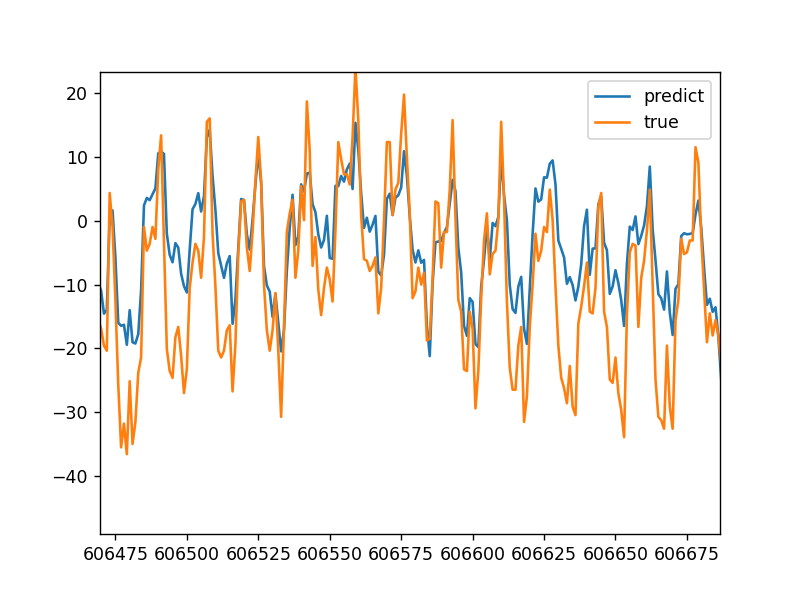

In [38]:
plt.figure()
plt.plot(ypred, label='predict')
plt.plot(scalpData, label='true')
plt.legend()
plt.show()